In [1]:
# !pip install numpy pandas matplotlib seaborn scikit-learn
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

In [57]:
import os
import torch
from torchvision import datasets,models, transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split
import pandas as pd
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data.sampler import WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

In [3]:
# read CSV
csv_path = 'image_labels_merged.csv'
df = pd.read_csv(csv_path, header=None, names=['image_name', 'label'])

# check data
print(df.head())

# Check the distribution of labels
print("distribution of labels:")
print(df['label'].value_counts())

# are there missing labels
missing_labels = df[df['label'].isnull()]
if not missing_labels.empty:
    print(f"null:\n{missing_labels}")
else:
    print("no missing label")


   image_name  label
0  asd_01.jpg      0
1  asd_02.jpg      0
2  asd_03.jpg      4
3  asd_04.jpg      2
4  asd_05.jpg      1
distribution of labels:
label
0    2067
4    1101
3     375
1     366
2     222
Name: count, dtype: int64
no missing label


# For create 16.000 data

In [48]:
# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label from the dataset
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Default transformations for images
default_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Augmented transformations for data augmentation
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize to 224x224
    transforms.RandomHorizontalFlip(),   # Random horizontal flip
    transforms.RandomRotation(15),      # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.ToTensor(),              # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Load the dataset from a CSV file
csv_file = 'image_labels_merged.csv'
img_dir = 'FADC-Dataset/All/'  # Directory containing images
original_data = pd.read_csv(csv_file, header=None, names=['image_name', 'label'])  # Read CSV with image names and labels

# Function to augment underrepresented classes in the dataset
def augment_data(data, class_label, multiplier):
    augmented_rows = []
    # Duplicate rows for the specified class
    for _, row in data[data['label'] == class_label].iterrows():
        for _ in range(multiplier - 1):  # Original data + (multiplier - 1) augmentations
            augmented_rows.append(row)
    return pd.DataFrame(augmented_rows, columns=data.columns)

# Augment specific classes (e.g., class 1, 2, 3)
augmented_rows = []
for class_label in [0]:  # Multiply class 0 by 2
    augmented_rows.append(augment_data(original_data, class_label, multiplier=2))
for class_label in [2]:  # Multiply class 2 by 5
    augmented_rows.append(augment_data(original_data, class_label, multiplier=5))
for class_label in [4, 5]:  # Multiply class 4 and 5 by 3
    augmented_rows.append(augment_data(original_data, class_label, multiplier=3))
for class_label in [1, 2, 3]:  # Multiply classes 1, 2, and 3 by 10
    augmented_rows.append(augment_data(original_data, class_label, multiplier=10))

# Combine all augmented rows into a single DataFrame
augmented_data = pd.concat(augmented_rows, ignore_index=True)

# Original dataset with default transformations
original_dataset = CustomImageDataset(data=original_data, img_dir=img_dir, transform=default_transform)

# Augmented dataset with augmented transformations
augmented_dataset = CustomImageDataset(data=augmented_data, img_dir=img_dir, transform=augmented_transform)

# Combine original and augmented datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Split the combined dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))  # 80% for training
val_size = len(combined_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)    # Do not shuffle validation data

# Apply default transformation for the validation dataset
val_dataset.dataset.transform = default_transform

In [49]:
# Print class distribution for the original dataset
original_labels = original_data['label']
print("Original Dataset Class Counts:")
print(original_labels.value_counts())

# Print class distribution for the augmented dataset
augmented_labels = augmented_data['label']
print("\nAugmented Dataset Class Counts:")
print(augmented_labels.value_counts())

# Print class distribution for the combined dataset
combined_labels = pd.concat([original_labels, augmented_labels], ignore_index=True)
print("\nCombined Dataset Class Counts:")
print(combined_labels.value_counts())


Original Dataset Class Counts:
label
0    2067
4    1101
3     375
1     366
2     222
Name: count, dtype: int64

Augmented Dataset Class Counts:
label
3    3375
1    3294
2    2886
4    2202
0    2067
Name: count, dtype: int64

Combined Dataset Class Counts:
label
0    4134
3    3750
1    3660
4    3303
2    3108
Name: count, dtype: int64


### Result        

Happy       0.80      0.65      0.71       804

Sad         0.53      0.67      0.59       781

Angry       0.57      0.77      0.65       643

Suprised    0.82      0.34      0.48       749

Neutral     0.41      0.52      0.46       614


accuracy                        0.59      3591

macro avg   0.63      0.59      0.58      3591

weightedavg 0.64      0.59      0.58      3591


Epoch [15/15]

Train Loss: 1.0222, Accuracy: 59.48%, Precision: 0.59, Recall: 0.59, F1-Score: 0.59

  Val Loss: 1.0641, Accuracy: 58.70%, Precision: 0.64, Recall: 0.59, F1-Score: 0.58

# for 8000 data create

In [66]:
# Custom Dataset Class
class CustomImageDataset(Dataset):
    def __init__(self, data, img_dir, transform=None):
        self.data = data
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the image path and label from the dataset
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert("RGB")
        label = int(self.data.iloc[idx, 1])
        
        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Default transformations for images
default_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Augmented transformations for data augmentation
augmented_transform = transforms.Compose([
    transforms.Resize((224, 224)),       # Resize to 224x224
    transforms.RandomHorizontalFlip(),   # Random horizontal flip
    transforms.RandomRotation(15),      # Random rotation within ±15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Adjust brightness, contrast, and saturation
    transforms.ToTensor(),              # Convert image to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std
])

# Load the dataset from a CSV file
csv_file = 'image_labels_merged.csv'
img_dir = 'FADC-Dataset/All/'  # Directory containing images
original_data = pd.read_csv(csv_file, header=None, names=['image_name', 'label'])  # Read CSV with image names and labels

# Function to augment underrepresented classes in the dataset
def augment_data(data, class_label, multiplier):
    augmented_rows = []
    # Duplicate rows for the specified class
    for _, row in data[data['label'] == class_label].iterrows():
        for _ in range(multiplier - 1):  # Original data + (multiplier - 1) augmentations
            augmented_rows.append(row)
    return pd.DataFrame(augmented_rows, columns=data.columns)

# Augment specific classes (e.g., class 1, 2, 3)
augmented_rows = []
for class_label in [2]:  # Multiply class 2 by 5
    augmented_rows.append(augment_data(original_data, class_label, multiplier=5))
for class_label in [4, 5]:  # Multiply class 4 and 5 by 3
    augmented_rows.append(augment_data(original_data, class_label, multiplier=2))
for class_label in [1, 2, 3]:  # Multiply classes 1, 2, and 3 by 10
    augmented_rows.append(augment_data(original_data, class_label, multiplier=5))

# Combine all augmented rows into a single DataFrame
augmented_data = pd.concat(augmented_rows, ignore_index=True)

# Original dataset with default transformations
original_dataset = CustomImageDataset(data=original_data, img_dir=img_dir, transform=default_transform)

# Augmented dataset with augmented transformations
augmented_dataset = CustomImageDataset(data=augmented_data, img_dir=img_dir, transform=augmented_transform)

# Combine original and augmented datasets
combined_dataset = ConcatDataset([original_dataset, augmented_dataset])

# Split the combined dataset into training and validation sets
train_size = int(0.8 * len(combined_dataset))  # 80% for training
val_size = len(combined_dataset) - train_size  # 20% for validation
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# DataLoaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Shuffle training data
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)    # Do not shuffle validation data

# Apply default transformation for the validation dataset
val_dataset.dataset.transform = default_transform

In [67]:
# Print class distribution for the original dataset
original_labels = original_data['label']
print("Original Dataset Class Counts:")
print(original_labels.value_counts())

# Print class distribution for the augmented dataset
augmented_labels = augmented_data['label']
print("\nAugmented Dataset Class Counts:")
print(augmented_labels.value_counts())

# Print class distribution for the combined dataset
combined_labels = pd.concat([original_labels, augmented_labels], ignore_index=True)
print("\nCombined Dataset Class Counts:")
print(combined_labels.value_counts())

Original Dataset Class Counts:
label
0    2067
4    1101
3     375
1     366
2     222
Name: count, dtype: int64

Augmented Dataset Class Counts:
label
2    1776
3    1500
1    1464
4    1101
Name: count, dtype: int64

Combined Dataset Class Counts:
label
4    2202
0    2067
2    1998
3    1875
1    1830
Name: count, dtype: int64


# Visualize

Random Samples from Original Dataset:


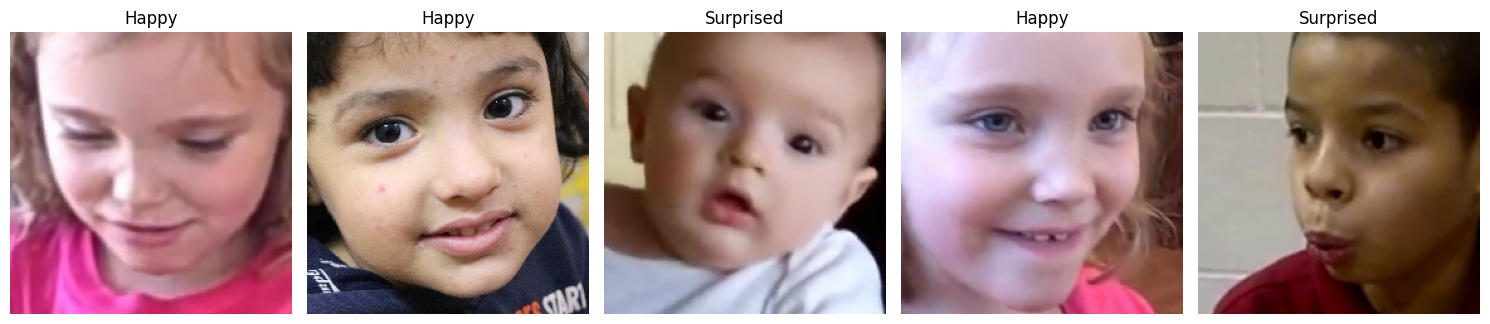

Random Samples from Augmented Dataset:


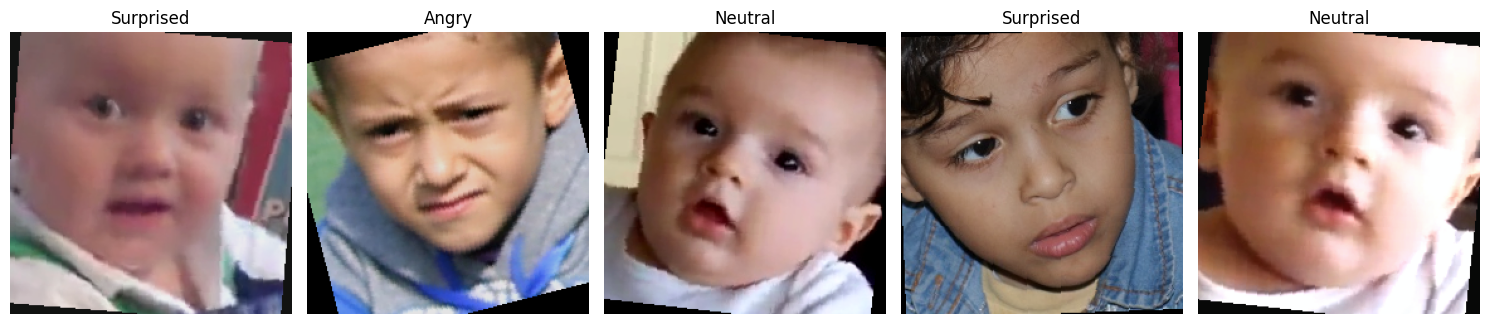

In [68]:
# Define class names
class_names = ["Happy", "Sad", "Angry", "Surprised", "Neutral"]
# Function to visualize random samples from a dataset
def visualize_random_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    random_indices = random.sample(range(len(dataset)), num_samples)  # Randomly select indices
    for i, idx in enumerate(random_indices):
        # Get the image and label at the random index
        image, label = dataset[idx]
        # Convert tensor image to numpy for visualization
        image = image.permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
        image = image.clip(0, 1)  # Clip values to be between 0 and 1
        axes[i].imshow(image)
        axes[i].set_title(f"{class_names[label]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Visualize random samples from the original dataset
print("Random Samples from Original Dataset:")
visualize_random_samples(original_dataset, num_samples=5)

# Visualize random samples from the augmented dataset
print("Random Samples from Augmented Dataset:")
visualize_random_samples(augmented_dataset, num_samples=5)


In [69]:
# Get indices for the train dataset
train_indices = train_dataset.indices if hasattr(train_dataset, 'indices') else range(len(train_dataset))

# Get labels for the combined dataset corresponding to train indices
train_labels = [combined_dataset[i][1] for i in train_indices]  # Labels for the specified indices

# Recalculate class counts
class_counts = pd.Series(train_labels).value_counts().sort_index()  # Count occurrences of each class
class_weights = 1. / class_counts  # Calculate weights for each class (inverse of the count)
sample_weights = [class_weights[label] for label in train_labels]  # Assign weights to each sample based on its label

# Use WeightedRandomSampler for balanced sampling
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# DataLoader for training dataset with sampler
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)

# DataLoader for validation dataset (no sampler, no shuffle)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Test: Check class weights and sample weights
print(f"Class Counts: {class_counts}")  # Print class counts
print(f"Sample Weights: {sample_weights[:10]}")  # Print the first 10 sample weights

Class Counts: 0    1649
1    1467
2    1592
3    1480
4    1789
Name: count, dtype: int64
Sample Weights: [np.float64(0.0005589714924538849), np.float64(0.0006756756756756757), np.float64(0.0006816632583503749), np.float64(0.0006064281382656155), np.float64(0.0006064281382656155), np.float64(0.000628140703517588), np.float64(0.000628140703517588), np.float64(0.0006064281382656155), np.float64(0.0005589714924538849), np.float64(0.0006064281382656155)]


In [70]:
# Create model
class EmotionDetectionModel(nn.Module):
    def __init__(self, num_classes=5):
        super(EmotionDetectionModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)

        for param in self.resnet.parameters():
            param.requires_grad = False  # Freeze labels

        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        for param in self.resnet.fc.parameters():
            param.requires_grad = True  # Trai only FC labels (last label) 

    def forward(self, x):
        return self.resnet(x)

model = EmotionDetectionModel(num_classes=5)
model.to('cuda')


C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\FURKAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EmotionDetectionModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [71]:
# loss funciton and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

def train_one_epoch(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        
        # Forward Pass
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        # Loss Calculation
        loss = criterion(outputs, labels)
        
        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    
    # Calculate F1, Precision, and Recall
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, precision, recall, f1


def validate(model, val_loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Metrics
            total_loss += loss.item()
            total += labels.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
    
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = 100 * correct / total

    # Calculate F1, Precision, and Recall
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    class_names = ["Happy", "Sad", "Angry", "Suprised", "Neutral"]
    print(classification_report(all_labels, all_preds, target_names=class_names))

    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds


class_names = ["Happy", "Sad", "Angry", "Suprised", "Neutral"]
# Training Loop
for epoch in range(15):
    # Train
    train_loss, train_accuracy, train_precision, train_recall, train_f1 = train_one_epoch(model, train_loader, optimizer, criterion)
    
    # Validate
    val_loss, val_accuracy, val_precision, val_recall, val_f1, all_labels, all_preds = validate(model, val_loader, criterion)
    
    # update learning rate
    scheduler.step(val_loss)

    # print classification report
    if epoch % 5 == 0:
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
    # Print metrics
    print(f"Epoch [{epoch+1}/10]")
    print(f"  Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%, Precision: {train_precision:.2f}, Recall: {train_recall:.2f}, F1-Score: {train_f1:.2f}")
    print(f"  Val Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%, Precision: {val_precision:.2f}, Recall: {val_recall:.2f}, F1-Score: {val_f1:.2f}")

              precision    recall  f1-score   support

       Happy       0.77      0.62      0.69       418
         Sad       0.36      0.62      0.46       363
       Angry       0.74      0.28      0.41       406
    Suprised       0.65      0.27      0.39       395
     Neutral       0.33      0.57      0.42       413

    accuracy                           0.47      1995
   macro avg       0.57      0.47      0.47      1995
weighted avg       0.57      0.47      0.47      1995

              precision    recall  f1-score   support

       Happy       0.77      0.62      0.69       418
         Sad       0.36      0.62      0.46       363
       Angry       0.74      0.28      0.41       406
    Suprised       0.65      0.27      0.39       395
     Neutral       0.33      0.57      0.42       413

    accuracy                           0.47      1995
   macro avg       0.57      0.47      0.47      1995
weighted avg       0.57      0.47      0.47      1995

Epoch [1/10]
  Train L

In [63]:
torch.save(model.state_dict(), 'emotion_detection_model.pth')

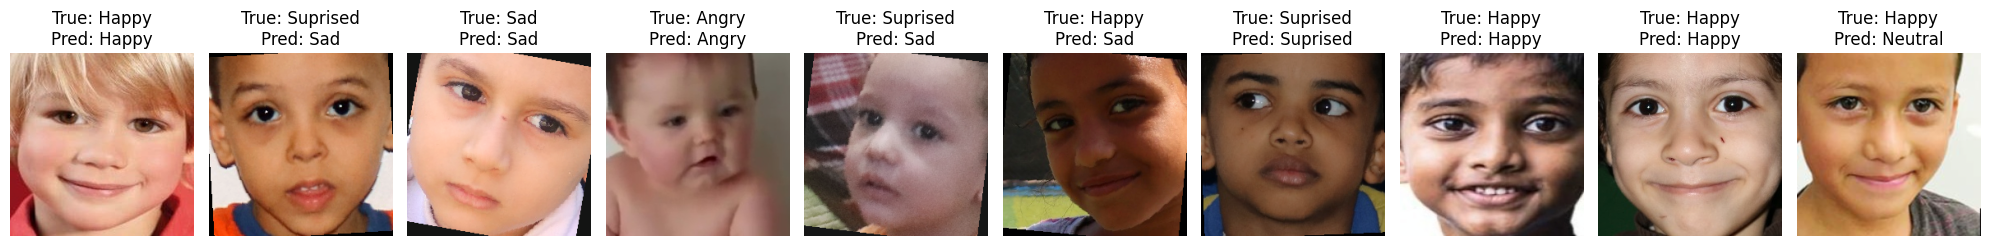

In [ ]:
# Function to visualize test results for 10 random samples
def visualize_test_results(model, dataset, class_names, num_samples=10):
    model.eval()
    random_indices = random.sample(range(len(dataset)), num_samples)  # Randomly select indices
    images = []
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for idx in random_indices:
            image, label = dataset[idx]
            images.append(image)
            true_labels.append(label)

            # Model prediction
            image = image.unsqueeze(0).to('cuda')  # Add batch dimension and move to GPU
            output = model(image)
            _, predicted = torch.max(output, 1)
            predicted_labels.append(predicted.item())

    # Plot the images with predictions and true labels
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        image = images[i].permute(1, 2, 0).numpy() * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
        image = image.clip(0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f"True: {class_names[true_labels[i]]}\nPred: {class_names[predicted_labels[i]]}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

# Example usage
visualize_test_results(model, val_dataset, class_names, num_samples=10)
